In [1]:
import torch
import torch.distributed as dist
from torch.utils.data import DataLoader, DistributedSampler
from torch.utils.data._utils.collate import default_collate
import random, numpy as np
import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
SRC_PATH = Path(os.getcwd()).parent / 'src' / 'spacenet'
DATA_DIR = Path(os.getcwd()).parent / 'data' / 'processed'
import sys
sys.path.append(str(SRC_PATH))
from dataset.data_processing import get_coords
from dataset.datasets import PathsDataset
from dataset.collate import TileCollator


In [2]:
def set_global_seed(seed: int):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)

In [3]:
seed = 42
set_global_seed(seed)
splits_path = DATA_DIR / 'metadata' / 'splits.csv'

In [4]:

splits_df = pd.read_csv(splits_path)

image_names = splits_df[splits_df['split']=='train']['image_name']

pre_image_dir = DATA_DIR / 'train' / 'PRE-event'
label_dir = DATA_DIR / 'train' / 'labels'

paths = [{'id': name,
        'pre-event image': str(pre_image_dir / f"{name}.png"),
        'labels': str(label_dir / f"labels_{get_coords(name)}.npy")} for name in image_names]



In [5]:
img_size = 1300
core_size = 512
halo_size = 32
stride = 256
num_tiles = 4
n_labels = 1
batch_size = -1
collate = TileCollator(img_size=img_size, core_size=core_size, halo_size=halo_size, stride=stride, num_tiles=num_tiles, random_selection=False, verbose=True)
if batch_size == -1:
    batch_size = len(paths)
    batch = paths
else:
    batch = paths[:batch_size]
    
collated = collate(batch)
assert 'pre-event image' in collated, "Collated batch missing 'pre-event image' key"
assert 'labels' in collated, "Collated batch missing 'labels' key"
expected_shape_data = torch.Size((batch_size*num_tiles, 3, core_size+2*halo_size, core_size+2*halo_size))
expected_shape_labels = torch.Size((batch_size*num_tiles, n_labels, core_size+2*halo_size, core_size+2*halo_size))
assert collated['pre-event image'].size() == expected_shape_data, f"Expected collated images shape {expected_shape_data}, got {collated['pre-event image'].size()}"
assert collated['labels'].size() == expected_shape_labels, f"Expected collated labels shape {expected_shape_labels}, got {collated['labels'].size()}"
assert torch.all(collated['pre-event image']>=0) and torch.all(collated['pre-event image']<=1), "Collated images should be normalized between 0 and 1"
assert torch.all(collated['labels'] >= 0) and torch.all(collated['labels'] <= 1), "Collated labels should be normalized between 0 and 1"


Sampled tile at: (614, 0)
Sampled tile at: (102, 0)
Sampled tile at: (0, 691)
Sampled tile at: (614, 788)
Refreshed grid with ux=102, uy=179, num_grid_x=5, num_grid_y=5, max_tiles=25


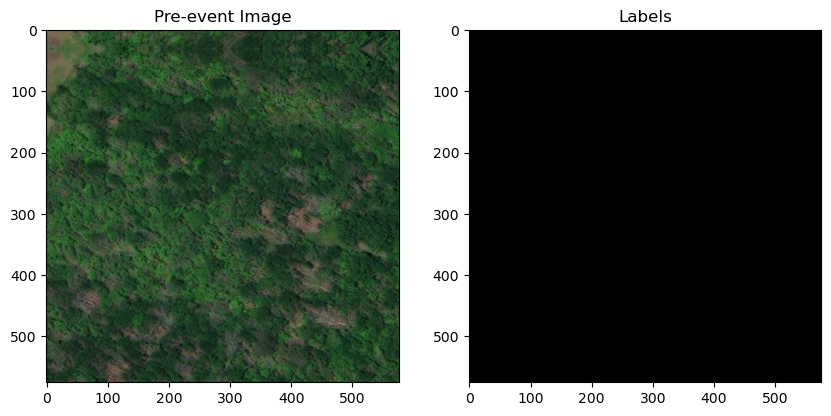

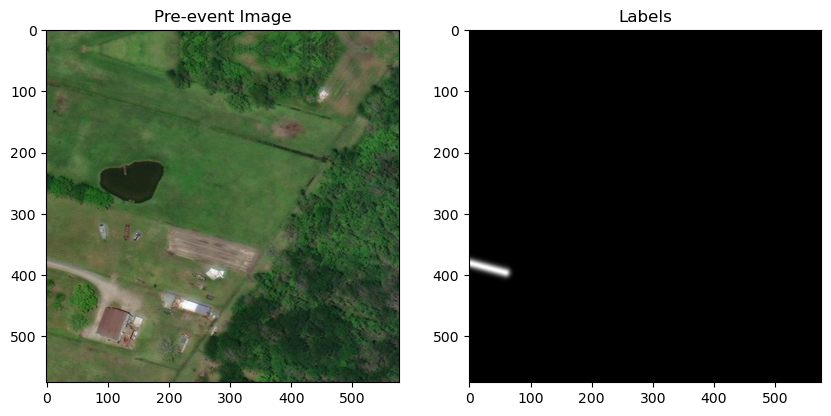

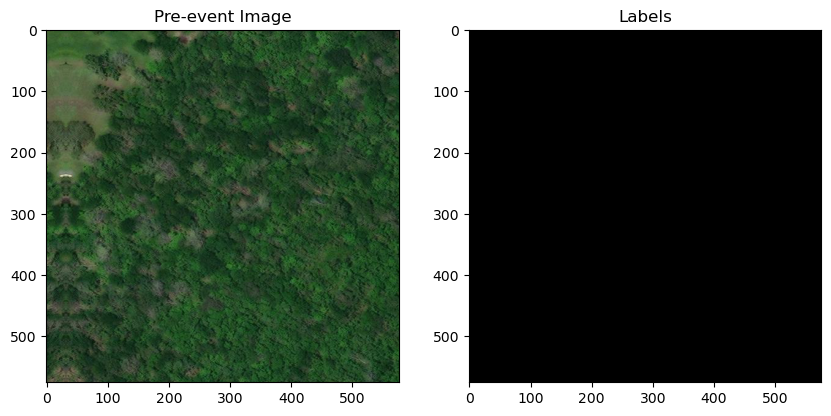

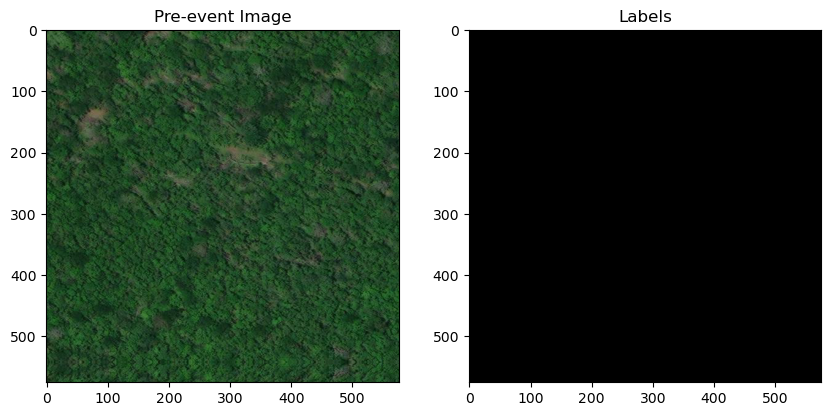

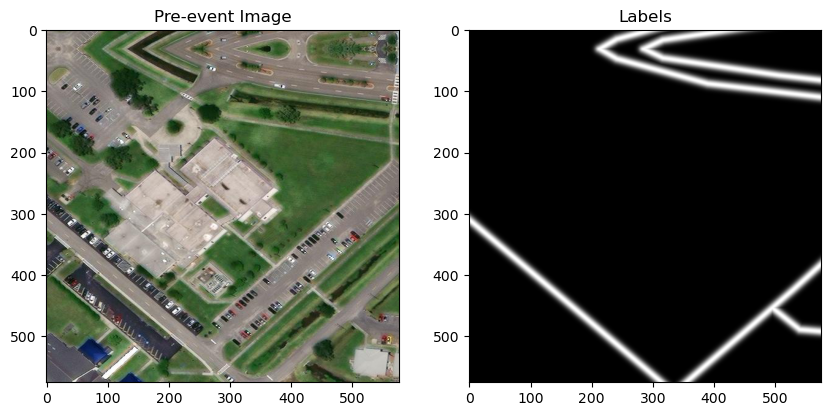

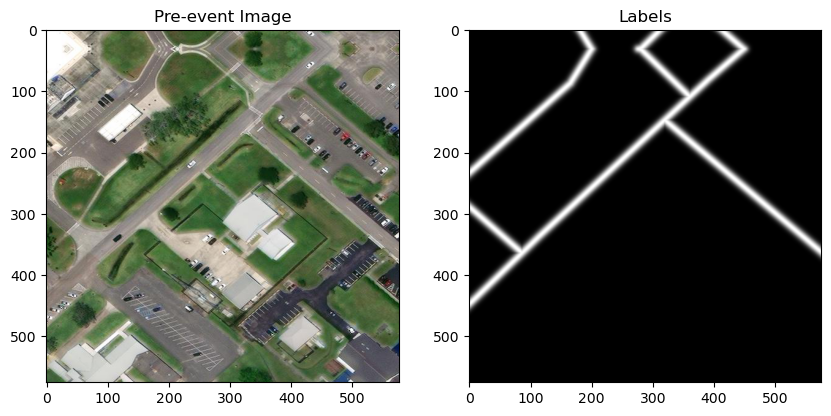

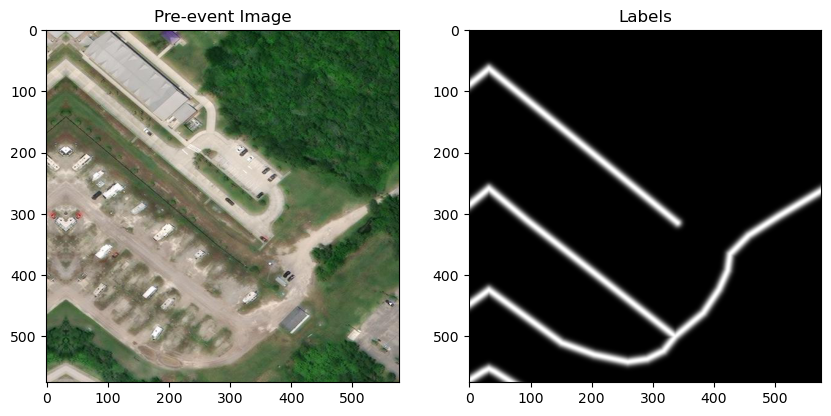

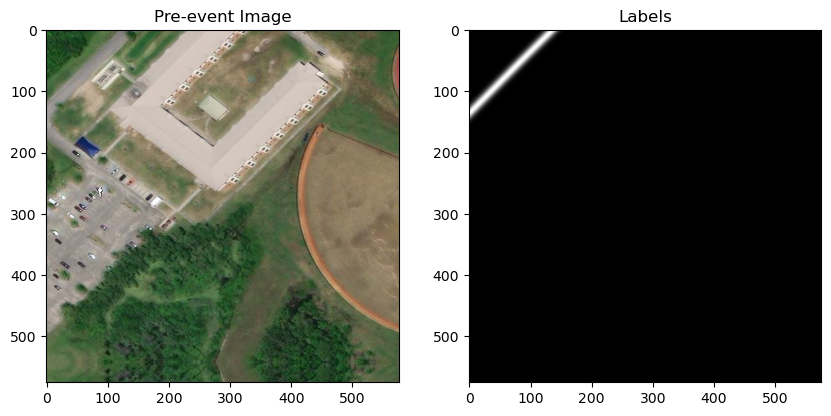

In [6]:
#view images and labels
for i in range(batch_size*num_tiles):
    fig, axs = plt.subplots(1,2, figsize=(10,5))
    img = collated['pre-event image'][i].permute(1,2,0).numpy()
    label = collated['labels'][i].squeeze().numpy()
    axs[0].imshow(img)
    axs[0].set_title('Pre-event Image')
    axs[1].imshow(label, cmap='gray')
    axs[1].set_title('Labels')
    plt.show()